## Visualize the results of the ML Robustness analyses

Here, we visualize the results of three robustness analyses:

1. Cell line holdout - train all 70 cell health models on every combination of 2 cell lines and predict on the third
2. Sample titration - remove samples from training and evaluate the impact on performance
3. Feature subgroup - systematically remove feature groups, channels, and compartments and evaluate impact on performance

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

source(file.path("..", "3.train", "scripts", "assay_themes.R"))

In [2]:
# Set seed
set.seed(123)

In [3]:
# Set constants
consensus <- "modz"
data_dir <- "results"
figure_dir <- "figures"
original_results_dir <- file.path("..", "3.train", "results")

# Input file names
cell_line_file <- file.path(
    data_dir, paste0("cell_line_holdout_robustness_results_", consensus, ".tsv.gz")
)
sample_titration_file <- file.path(
    data_dir, paste0("sample_titration_robustness_results_", consensus, ".tsv.gz")
)
feature_group_file <- file.path(
    data_dir, paste0("feature_group_subset_removal_robustness_results_", consensus, ".tsv.gz")
)
original_results_file <- file.path(
    original_results_dir, paste0("full_cell_health_regression_", consensus, ".tsv.gz")
)
label_file <- file.path(
    "..",
    "1.generate-profiles",
    "data",
    "labels",
    "feature_mapping_annotated.csv"
)

# Output file names
cell_line_figure_file <- file.path(
    figure_dir, paste0("cell_line_holdout_", consensus, ".png")
)

sample_titration_figure_file <- file.path(
    figure_dir, paste0("sample_titration_", consensus, ".png")
)

feature_removal_figure_file <- file.path(
    figure_dir, paste0("feature_removal_", consensus, ".png")
)

In [4]:
# Load data
cell_line_df <- readr::read_tsv(cell_line_file, col_types = readr::cols())
sample_df <- readr::read_tsv(sample_titration_file, col_types = readr::cols())
feature_df <- readr::read_tsv(feature_group_file, col_types = readr::cols())
original_df <- readr::read_tsv(original_results_file, col_types = readr::cols())

original_df$shuffle <- original_df$shuffle %>%
    dplyr::recode_factor(
        "shuffle_false" = "Real",
        "shuffle_true" = "Permuted"
    )

# Label variables with specific cell health classes
label_df <- readr::read_csv(label_file, col_types = readr::cols())

### 1. Visualize cell line holdout results

In [5]:
cell_line_df <- cell_line_df %>%
    dplyr::filter(metric == "r_two", data_fit == "test") %>%
    dplyr::left_join(label_df, by = c("target" = "id")) 

cell_line_df$shuffle <- cell_line_df$shuffle %>%
    dplyr::recode_factor(
        "shuffle_false" = "Real",
        "shuffle_true" = "Permuted"
    )

cell_line_df$measurement <- dplyr::recode(cell_line_df$measurement, "metadata" = "other")

cell_line_df$measurement_ordered <- dplyr::recode_factor(cell_line_df$measurement, !!!measurement_labels)
cell_line_df$measurement_ordered <- dplyr::recode_factor(
    cell_line_df$measurement_ordered, `Reactive Oxygen Species` = "ROS", `Infection Efficiency` = "Inf. Efficiency"
)

assay_measurement_order <- cell_line_df %>%
    dplyr::filter(shuffle == "Real", cell_line == "A549") %>%
    dplyr::group_by(measurement_ordered) %>%
    dplyr::mutate(median_measure = median(value)) %>%
    dplyr::select(measurement_ordered, median_measure) %>%
    dplyr::distinct() %>%
    dplyr::arrange(desc(median_measure)) %>%
    dplyr::pull(measurement_ordered)

cell_line_df$measurement_ordered <- factor(
    cell_line_df$measurement_ordered, levels = assay_measurement_order
)

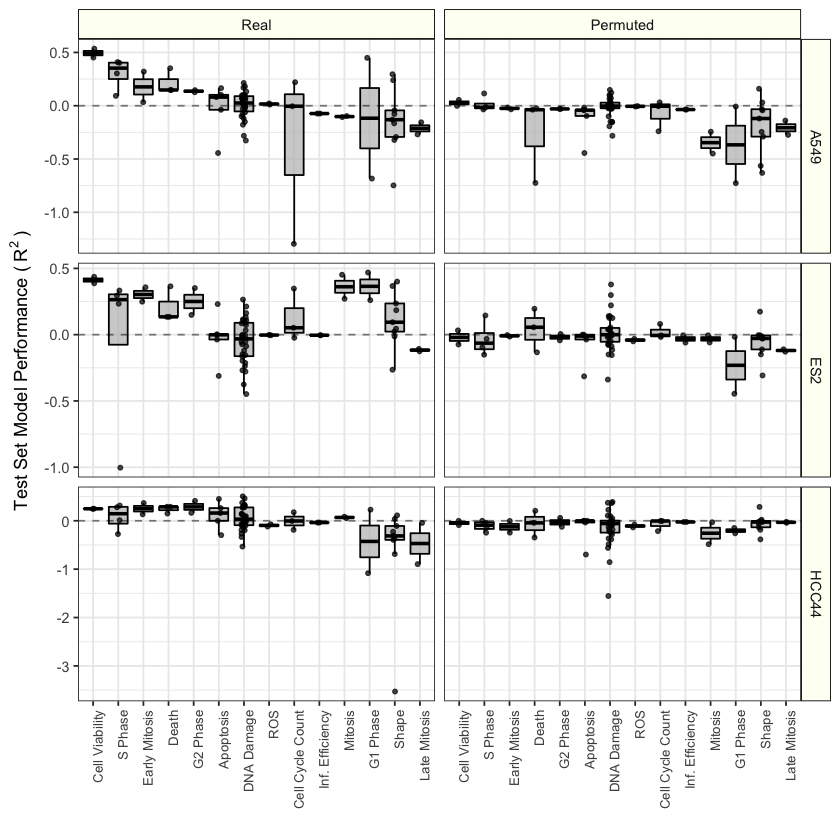

In [6]:
cell_line_gg <- ggplot(cell_line_df,
       aes(y = value, x = measurement_ordered)) +
    geom_boxplot(fill = "grey",
                 alpha = 0.72,
                 size = 0.5,
                 color = "black",
                 outlier.alpha = 0) +
     geom_jitter(fill = "black",
                 alpha = 0.72,
                 size = 1,
                 shape = 21,
                 width = 0.1,
                 color = "black") +
    ylab(bquote("Test Set Model Performance ("~R^2~")")) +
    xlab("") +
    geom_hline(yintercept = 0,
               alpha = 0.5, 
               linetype = "dashed") +
    facet_grid(cell_line~shuffle, scales = "free_y") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8),
          legend.position = "none",
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

ggsave(cell_line_figure_file, cell_line_gg, dpi = 500, width = 7, height = 5)
cell_line_gg

### 2. Visualize sample titration results

In [7]:
# Append original results to sample titration
sample_df <- sample_df %>% dplyr::bind_rows(
    original_df %>%
        dplyr::filter(shuffle == "shuffle_false", cell_line == "all") %>%
        dplyr::mutate(num_samples_dropped = 0, iteration = 0)
) %>%
    dplyr::left_join(label_df, by = c("target" = "id")) %>%
    dplyr::group_by(target, num_samples_dropped) %>%
    dplyr::mutate(mean_value = mean(value)) %>%
    dplyr::ungroup() %>%
    dplyr::filter(data_fit == "test", metric == "r_two") %>%
    dplyr::arrange(mean_value) %>%
    dplyr::distinct(target, num_samples_dropped, mean_value, readable_name, measurement)

target_order <- sample_df %>%
    dplyr::arrange(desc(mean_value)) %>%
    dplyr::distinct(readable_name) %>%
    dplyr::pull(readable_name)

sample_df$readable_name <- factor(sample_df$readable_name, levels=target_order)

# Recode metadata measurent to other
sample_df$measurement <- dplyr::recode(sample_df$measurement, "metadata" = "other")

sample_df$measurement <- factor(sample_df$measurement, levels = c(
    "cell_viability",
    "death",
    "apoptosis",
    "ros",
    "dna_damage",
    "g1_phase",
    "s_phase",
    "g2_phase",
    "early_mitosis",
    "mitosis",
    "late_mitosis",
    "cell_cycle_count",
    "shape",
    "other"
))

print(dim(sample_df))
head(sample_df, 3)

Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

[1] 1750    5


target,num_samples_dropped,mean_value,readable_name,measurement
<chr>,<dbl>,<dbl>,<fct>,<fct>
cc_mitosis_high_h2ax,24,0.04945638,M - % High gH2AX Spots,dna_damage
cc_mitosis_high_h2ax,2,0.05073405,M - % High gH2AX Spots,dna_damage
cc_mitosis_high_h2ax,1,0.05094817,M - % High gH2AX Spots,dna_damage


In [8]:
avg_results_full_df <- sample_df %>%
    dplyr::group_by(num_samples_dropped) %>%
    dplyr::mutate(mean_total_estimate = mean(mean_value)) %>%
    dplyr::distinct(num_samples_dropped, mean_total_estimate)

head(avg_results_full_df)

num_samples_dropped,mean_total_estimate
<dbl>,<dbl>
24,0.3424461
2,0.3455589
1,0.3446846
3,0.3452432
22,0.3435761
21,0.3430882


In [9]:
sample_gg <- (
    ggplot(sample_df, aes(x = num_samples_dropped, y = mean_value)) +
        geom_line(aes(color = measurement, group = target)) +
        ylab(bquote("Test set "~R^2~"")) +
        xlab("Number of samples\ndropped from training") +
        scale_color_manual(
            name = "Measurement",
            values = measurement_colors,
            labels = measurement_labels
        ) +
        theme_bw()
    )

In [10]:
avg_drop_gg <- ggplot(avg_results_full_df,
                   aes(x = num_samples_dropped, y = mean_total_estimate)) +
    geom_point(
        data = ,
        color = "black",
        size = 1.5)  +
    geom_line(
        data = avg_results_full_df,
        color = "black",
        size = 0.75
    ) +
    theme_bw() +
    xlab("Number of samples\ndropped from training") +
    ylab(bquote("Test set "~R^2~"\n(Mean for all Cell Health targets)"))

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font metrics unknown for character 0xa”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font metrics unknown for character 0xa”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font metrics unknown for character 0xa”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font metrics unknown for character 0xa”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font metrics unknown for character 0xa”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font metrics unknown for character 0xa”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font metrics unknown for character 0xa”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font metrics unknown for character 0xa”Warning message in grid.

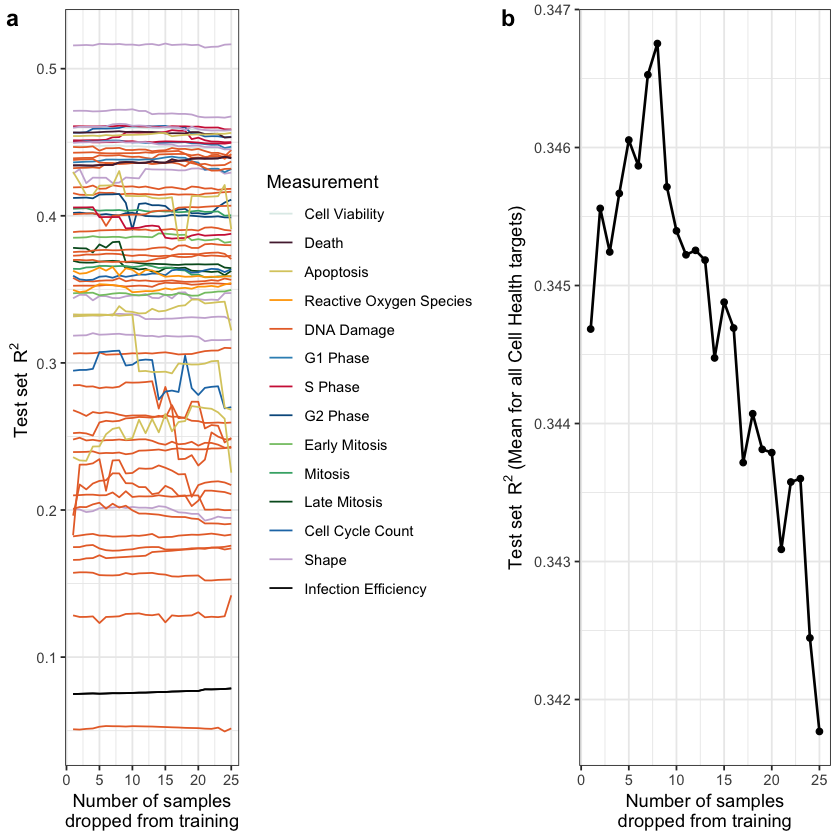

In [11]:
sample_titration_gg <- cowplot::plot_grid(
    sample_gg,
    avg_drop_gg,
    ncol = 2,
    align = "h",
    axis = "l",
    rel_widths = c(1, 0.7),
    labels = c("a", "b")
)

cowplot::save_plot(sample_titration_figure_file, sample_titration_gg, base_width = 10, base_height = 6)
sample_titration_gg

### 3. Visualize feature group removal

In [12]:
feature_df <- feature_df %>%
    dplyr::filter(metric == "r_two", data_fit == "test") %>%
    dplyr::left_join(label_df, by = c("target" = "id")) %>%
    dplyr::mutate()

feature_df$measurement <- dplyr::recode(feature_df$measurement, "metadata" = "other")

feature_df$measurement_ordered <- dplyr::recode_factor(feature_df$measurement, !!!measurement_labels)
feature_df$measurement_ordered <- dplyr::recode_factor(
    feature_df$measurement_ordered, `Reactive Oxygen Species` = "ROS", `Infection Efficiency` = "Inf. Efficiency"
)

assay_measurement_order <- feature_df %>%
    dplyr::group_by(measurement_ordered) %>%
    dplyr::mutate(median_measure = median(value)) %>%
    dplyr::select(measurement_ordered, median_measure) %>%
    dplyr::distinct() %>%
    dplyr::arrange(desc(median_measure)) %>%
    dplyr::pull(measurement_ordered)

feature_df$measurement_ordered <- factor(
    feature_df$measurement_ordered, levels = assay_measurement_order
)

feature_df <- feature_df %>% dplyr::left_join(
    original_df %>%
        dplyr::filter(
            shuffle == "Real",
            cell_line == "all",
            data_fit == "test",
            metric == "r_two"
        ) %>%
        dplyr::select(value, target),
    by = "target",
    suffix = c("", "_original")
    ) %>%
    dplyr::mutate(feature_group_difference = value_original - value,
                  feature_group_name = paste0(feature_type_dropped, " (n = ", num_dropped, ")"))

feature_order <- feature_df %>%
    dplyr::group_by(readable_name) %>%
    dplyr::mutate(median_measure = mean(feature_group_difference)) %>%
    dplyr::select(readable_name, median_measure) %>%
    dplyr::distinct() %>%
    dplyr::ungroup() %>%
    dplyr::arrange(median_measure) %>%
    dplyr::pull(readable_name)

feature_df$readable_name <- factor(
    feature_df$readable_name, levels = feature_order
)

In [13]:
head(feature_df, 2)

value,metric,target,data_fit,shuffle,y_transform,cell_line,feature_category,feature_type_dropped,num_dropped,⋯,gh2ax,caspase,draq7,cell_rox,dpc,description,measurement_ordered,value_original,feature_group_difference,feature_group_name
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<chr>,<fct>,<dbl>,<dbl>,<chr>
0.3663792,r_two,cc_all_high_h2ax,test,shuffle_false,raw,all,feature_group,Texture,397,⋯,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,DNA Damage,0.3290470,-0.03733213,Texture (n = 397)
0.1880848,r_two,cc_all_large_notround_polynuclear_mean,test,shuffle_false,raw,all,feature_group,Texture,397,⋯,0,0,0,0,0,Fraction of cells with large non-round nuclei (Polynuclear),Shape,0.2394573,0.05137251,Texture (n = 397)


In [14]:
feature_theme <- theme(
    axis.title = element_text(size = 7),
    axis.text.y = element_text(size = 6),
    legend.text = element_text(size = 8),
    legend.title = element_text(size = 9)
)

In [15]:
panel_a_gg <- ggplot(
        feature_df %>% dplyr::filter(feature_category == "feature_group"),
        aes(x = feature_group_name, y = feature_group_difference)
    ) +
    coord_flip() +
    geom_boxplot(outlier.size = 0.5) +
    theme_bw() +
    feature_theme +
    ylim(c(
        min(feature_df$feature_group_difference) - 0.1,
        max(feature_df$feature_group_difference + 0.1)
    )) +
    geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
    xlab("Feature Group") +
    ylab("Performance difference\n(Original - Feature group dropped)")

In [16]:
panel_b_gg <- ggplot(
        feature_df %>% dplyr::filter(feature_category == "channel"),
        aes(x = feature_group_name, y = feature_group_difference)
    ) +
    coord_flip() +
    geom_boxplot(outlier.size = 0.5) +
    theme_bw() +
    feature_theme +
    ylim(c(
        min(feature_df$feature_group_difference) - 0.1,
        max(feature_df$feature_group_difference + 0.1)
    )) +
    geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
    xlab("Channel") +
    ylab("Performance difference\n(Original - Channel dropped)")

In [17]:
panel_c_gg <- ggplot(
        feature_df %>% dplyr::filter(feature_category == "compartment"),
        aes(x = feature_group_name, y = feature_group_difference)
    ) +
    coord_flip() +
    geom_boxplot(outlier.size = 0.5) +
    theme_bw() +
    feature_theme +
    geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
    ylim(c(
        min(feature_df$feature_group_difference) - 0.1,
        max(feature_df$feature_group_difference + 0.1)
    )) +
    xlab("Compartment") +
    ylab("Performance difference\n(Original - Compartment dropped)")

In [18]:
panel_d_gg <- ggplot(feature_df,
                     aes(x = readable_name,
                         y = feature_group_difference,
                         fill = measurement)) +
    geom_boxplot(outlier.size = 0.5) +
    coord_flip() +
    scale_fill_manual(
        name = "Measurement",
        values = measurement_colors,
        labels = measurement_labels
    ) +
    theme_bw() +
    feature_theme +
    geom_hline(yintercept=0, color = "red", linetype = "dashed") +
    ylab("Performance difference\n(Original - Feature group dropped)") +
    xlab("")

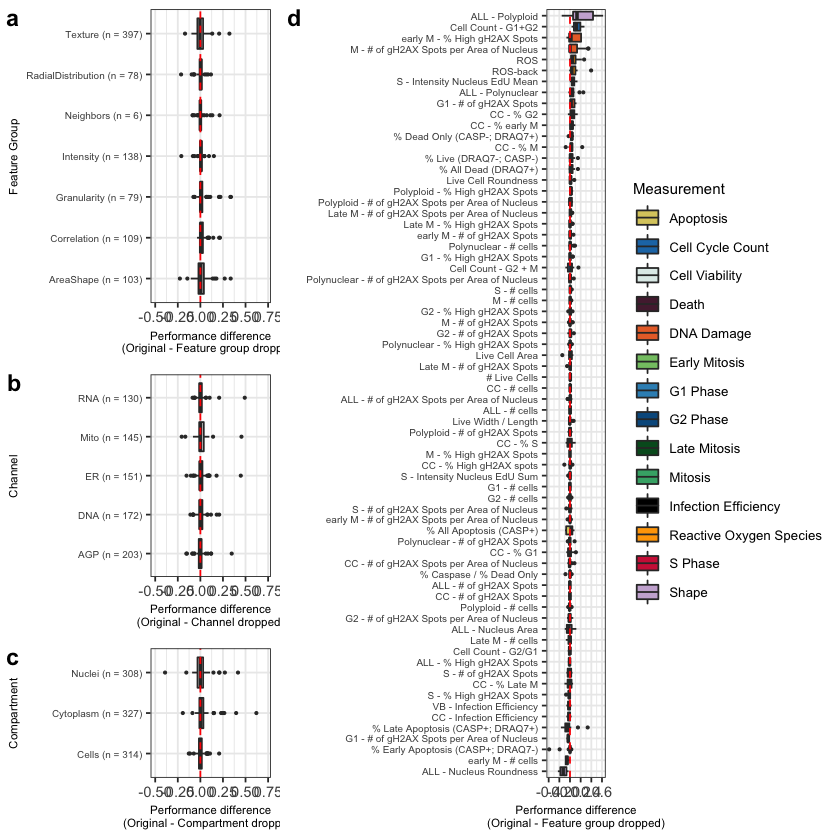

In [19]:
left_panel <- cowplot::plot_grid(
    panel_a_gg,
    panel_b_gg,
    panel_c_gg,
    nrow = 3,
    align = "hv",
    axis = "l",
    rel_heights = c(1, 0.75, 0.55),
    labels = c("a", "b", "c")
)

feature_removal_gg <- cowplot::plot_grid(
    left_panel,
    panel_d_gg,
    ncol = 2,
    align = "v",
    axis = "b",
    rel_widths = c(0.5, 1),
    labels = c("", "d")
)

cowplot::save_plot(feature_removal_figure_file, feature_removal_gg, base_width = 9, base_height = 6)
feature_removal_gg